In [20]:
import sys
import glob
import pickle
import gensim
import pandas as pd
import numpy as np

sys.path.append('../src/')
from clio import *

# Imports for data viz
import re
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
github_data = pd.concat([pd.read_csv(filename) for filename in glob.glob('../data/raw/github_data/*')])
github_data = github_data[github_data['project_description'].isnull()==False]
github_data['project_year'] = github_data.project_creation_date.apply(lambda x: x[:4])
github_data.reset_index(inplace=True, drop=True)

/Users/kstathou/anaconda/envs/nesta/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/kstathou/anaconda/envs/nesta/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/Users/kstathou/anaconda/envs/nesta/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
# Load pretrained word and document vectors
word_vectors = gensim.models.Word2Vec.load('../models/w2v_gh.word2vec')
doc_vectors = gensim.models.Doc2Vec.load('../../../clio_search/models/d2v_v1.doc2vec')

with open('../data/interim/docs_gh.pickle', 'rb') as h:
    docs = pickle.load(h)

In [4]:
clio = Clio(github_data, docs, word_vectors, doc_vectors)

In [ ]:
# ML query
ml = clio.search_queries(token='machine_learning', sim_tokens=40, bottom_lim=35, upper_lim=95)
ml['topic'] = 'Machine\nLearning'

# VR query
vr = clio.search_queries(token='virtual_reality', sim_tokens=40, bottom_lim=35, upper_lim=95)
vr['topic'] = 'Virtual\nReality'

# Robotics query
robots = clio.search_queries(token='robots', sim_tokens=40, bottom_lim=35, upper_lim=95)
robot['topic'] = 'Robotics'

# Blockchain query
blockchain = clio.search_queries(token='blockchain', sim_tokens=40, bottom_lim=35, upper_lim=95)
blockchain['topic'] = 'Blockchain'

In [15]:
topics = pd.concat([ml, vr, robot, blockchain])

In [18]:
topics_in_countries = topics.groupby(['user_country_code', 'topic']).count()['project_id'].unstack('topic')
users_in_countries = topics.drop_duplicates('user_id').groupby(['user_country_code', 'topic']).count()['user_id'].unstack('topic')
topics_years = topics.groupby(['project_year', 'topic']).count()['project_id'].loc['2009':'2017', ]
total_projects = github_data.groupby('project_year').count()['project_id'].loc['2009':'2017']
topics_years_percent = topics_years / total_projects

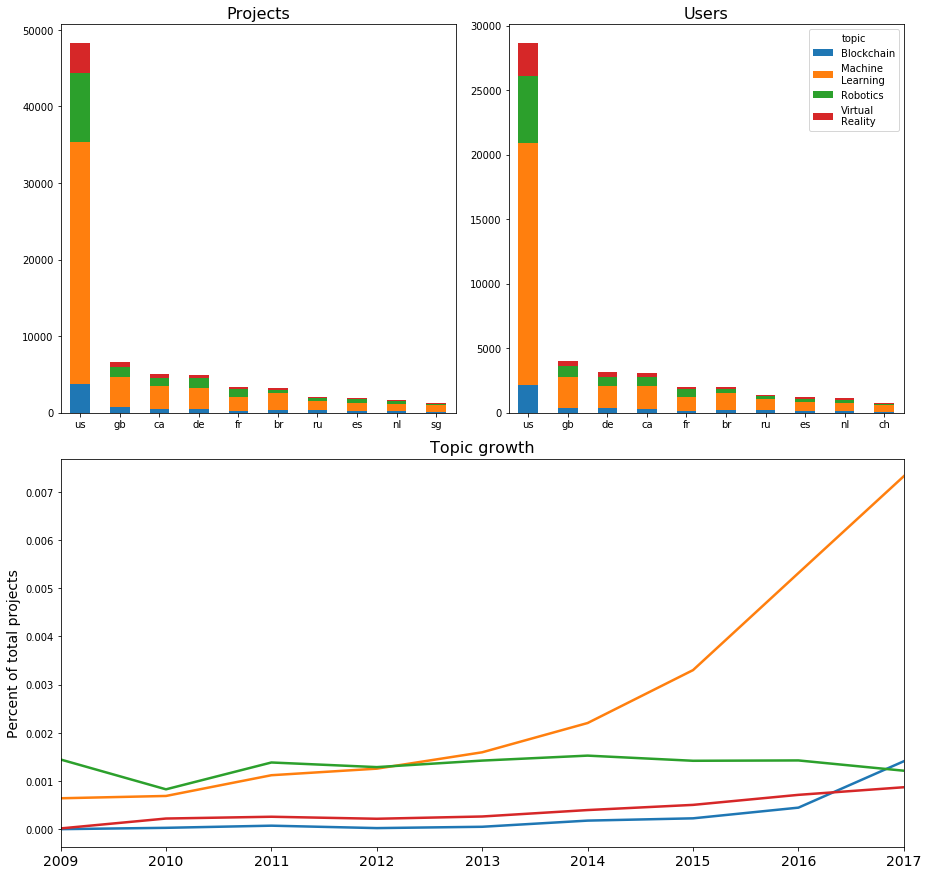

In [22]:
f = plt.figure(figsize=(13,18))
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0, 0])
topics_in_countries.loc[topics_in_countries.T.sum().sort_values(ascending=False).index[:10], ].plot(kind='bar', stacked=True, rot=0, ax=ax1, legend=False)
ax1.set_title('Projects', fontsize=16)
ax1.set_xlabel('')

ax2 = plt.subplot(gs[0, 1])
users_in_countries.loc[users_in_countries.T.sum().sort_values(ascending=False).index[:10],:].plot(kind='bar', stacked=True, ax=ax2, rot=0)
ax2.set_title('Users', fontsize=16)
ax2.set_xlabel('')

ax3 = plt.subplot(gs[1, :])
unstacked_topics = topics_years_percent.unstack('topic').fillna(0)
unstacked_topics.plot(ax=ax3, linewidth=2.5, legend=False)
ax3.set_title('Topic growth', fontsize=16)
ax3.set_ylabel('Percent of total projects', fontsize=14)
ax3.set_xlabel('')
ax3.set_xticklabels(unstacked_topics.index, fontsize=14)

plt.tight_layout()
f.savefig('../gh_topics.pdf')
plt.show()